# AH2179 Applied AI in Transportation
## Module 2: Use regression models to predict bus arrival delays
### Nutta Sittirash

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)
df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


In [4]:
# Use only 1xxx records
#df = df.iloc[:1500]

In [5]:
# Remove unneeded columns which are basic information and remain only operation information
df = df.drop(['Arrival_time', 'Stop_id','Bus_id','Line_id'], axis=1)

In [16]:
# df.describe()

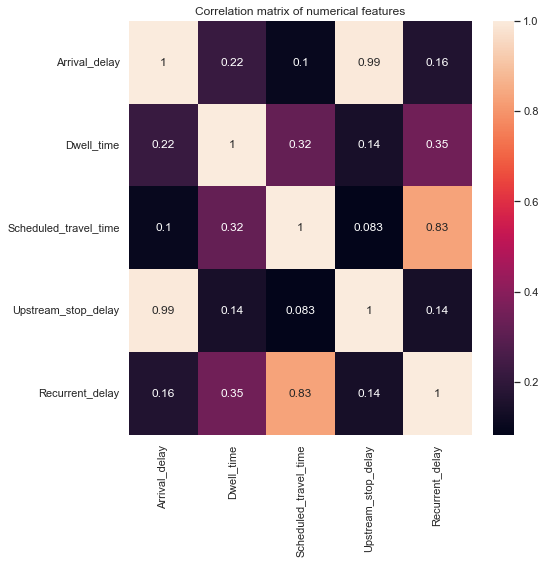

In [7]:
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)
plt.subplots(figsize=(8,8))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation matrix of numerical features")
plt.tight_layout()
plt.show()

### Side Note:
The correlation matrix indicates that Upstream_stop_delay has strongly influenced Arrival_delay at Linnégatan.\
Bus line 1 starts at Essingetorget and end at Frihamnen. 
From the dataset (the arrival delays at Linnégatan), the upstrean station of it would be Humlegården and the downstream would be Stureplan. 

In [8]:
# Define y as dependent variables and the others as x independent variables
x = df.drop(['Arrival_delay'], axis = 1)
y = df['Arrival_delay']

### Creating and training the model using XGBoost 

In [17]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost Regressor Model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state = 42)

# Avoid random seeds to effect the outcomes
cross_val_score(model, x, y, cv=5).mean()

# Split the dataset into a training and a test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 11.872192595735056
Mean Squared Error: 263.8666340613594
R-squared: 0.991151341394846


### Applying model training teachniques (SVM)

Hyperparameter Tuning

In [10]:
# Normallize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {   # Define parameters grid for hyperparameter tuning
    #'n_estimators': [1800, 1900, 2179],
    #'learning_rate': [0.01, 0.02, 0.03],
    #'max_depth': [1, 2, 3],
    #'gamma': [0, 0.01, 0.25],
    #'min_child_weight': [1, 2, 3]
    'n_estimators': [2179],        
    'learning_rate': [0.03],
    'max_depth': [1],
    'gamma': [0],                 # a third value affects accuracy
    'min_child_weight': [1]       # Control overfitting to determine how many data points in a leaf node
}
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid = param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train) # Fit the grid search to the scaled training

best_params = grid_search.best_params_   # Get the best parameters

#### Implementing the model by considering the best parameters
#### Make prediction

In [11]:
optimal_model = xgb.XGBRegressor(objective='reg:squarederror', random_state = 42, ** best_params)
optimal_model.fit(X_train_scaled, y_train)
y_pred = optimal_model.predict(X_test_scaled)
print("Best Parameters:", best_params)

Best Parameters: {'gamma': 0, 'learning_rate': 0.03, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 2179}


In [12]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", MAE)
print("Mean Squared Error:", MSE)
print("Root Mean Squared Error:", RMSE)
print("R-squaed:", R2)

Mean Absolute Error: 10.625621887043529
Mean Squared Error: 201.41451049303882
Root Mean Squared Error: 14.192058007668896
R-squaed: 0.9932456475680715


### Visualize the results

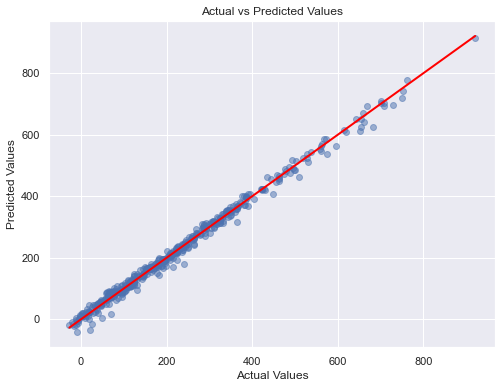

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test,y_pred, alpha = 0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color='red', lw='2')
plt.show()

#### Side note

#### With the data of 1000 records 

**when using StandardScaler, the results are as follow.** 

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}\
Test Mean Squared Error: 231.78658320452294\
R-squaed: 0.9906780908247284

**when using MinMaxScaler, the results are as follow.** 

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}\
Test Mean Squared Error: 232.52210566630143\
R-squaed: 0.9906485098477353

**without normalization the data, the results are as follow.** (same as normalized data)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}\
Test Mean Squared Error: 231.78658320452294\
R-squaed: 0.9906780908247284

**when using 3000 trees**\
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 3000}\
Mean Squared Error: 214.38751682154071\
Root Mean Squared Error: 14.641977899913\
R-squaed: 0.9913778401989773\
**However, it doesn't make sense to use 3000 trees in 1000 records of the data**

#### With the data of the whole records 

**With the data of the whole records, 2179**\
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 2179}\
Mean Squared Error: 215.492871490921\
Root Mean Squared Error: 14.67967545591254\
R-squaed: 0.9927735355458998

### Final results
**When adopting SVM and considering more parameters in GridSearchCV**\
Best Parameters: {'gamma': 0, 'learning_rate': 0.03, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 2179}\
Mean Absolute Error: 10.625621887043529\
Mean Squared Error: 201.41451049303882\
Root Mean Squared Error: 14.192058007668896\
R-squaed: 0.9932456475680715
